Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import pickle

Loading dataset

In [ ]:
# Upload data from github
!git clone https://github.com/Zoriannn/MoodSound

# Load data
data = pd.read_csv('./MoodSound/mxmh_survey_results.csv', encoding = 'unicode_escape')
data.head()

Cloning into 'MoodSound'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 26.74 KiB | 5.35 MiB/s, done.
Resolving deltas: 100% (2/2), done.


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    object 
 13  Frequ

##Data preprocessing

Data cleaning

In [ ]:
# Drop unwanted columns
data.drop(['Age','Timestamp','Permissions','Primary streaming service',
           'While working', 'Instrumentalist', 'Composer','Exploratory',
           'Foreign languages','Music effects','Frequency [Classical]', 'Frequency [Country]',
       'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]',
       'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]',
       'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]',
       'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]',
       'Frequency [Rock]', 'Frequency [Video game music]'], axis=1, inplace=True)

In [ ]:
# Check for null values
data.isna().sum()

Hours per day      0
Fav genre          0
BPM              107
Anxiety            0
Depression         0
Insomnia           0
OCD                0
dtype: int64

In [ ]:
# Fill null values with mean
data['BPM'].fillna(data['BPM'].mean(), inplace=True)

# Check again for null values
data.isna().sum()

Hours per day    0
Fav genre        0
BPM              0
Anxiety          0
Depression       0
Insomnia         0
OCD              0
dtype: int64

In [ ]:
#Removing outliers
data_index = data[data['BPM'] > 200].index
data = data.drop(data_index, axis=0)

Encoding

In [ ]:
# Categorical columns
data.select_dtypes(include=['object']).columns

Index(['Fav genre'], dtype='object')

In [ ]:
# Convert values above 7.5 to True, and values 7.5 or below to False
for column in ['Anxiety', 'Depression', 'Insomnia', 'OCD']:
    data[column] = data[column] > 7.5

In [ ]:
# Encode 'Fav genre'
columns = data['Fav genre']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Fav genre' column
encoded_fav_genre = label_encoder.fit_transform(columns)

# Create a mapping dictionary
genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Update the 'Fav genre' column in the DataFrame with the encoded values
data['Fav genre'] = encoded_fav_genre

data.head()

,Hours per day,Fav genre,BPM,Anxiety,Depression,Insomnia,OCD
0,3.0,8,156.0,False,False,False,False
1,1.5,14,119.0,False,False,False,False
2,4.0,15,132.0,False,False,True,False
3,2.5,6,84.0,True,False,False,False
4,4.0,12,107.0,False,False,False,True


Correlation matrix

<Axes: >

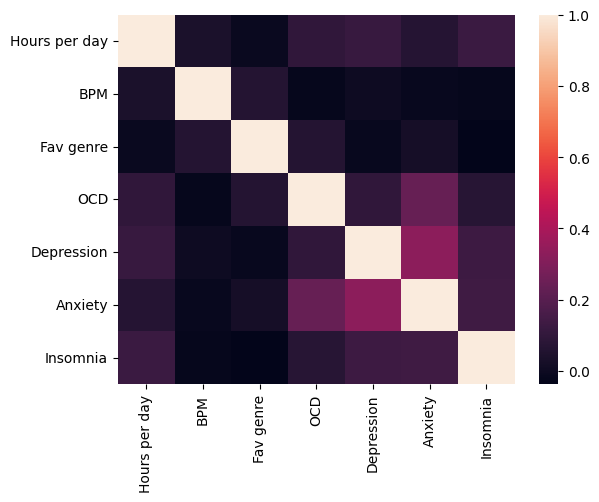

In [ ]:
# showing correlation matrix
columns_to_correlate = ['Hours per day', 'BPM', 'Fav genre','OCD', 'Depression', 'Anxiety', 'Insomnia']

correlation_data = data[columns_to_correlate]

# Create heatmap
sns.heatmap(correlation_data.corr())

In [ ]:
# Checking the classes in our target variables
columns = ['Anxiety','Depression', 'Insomnia', 'OCD']
for column in columns:
    print(f"Column: {column}")
    print(data[column].value_counts())
    print("\n")

# Class imbalance, need to customise class weight

Column: Anxiety
False    417
True     203
Name: Anxiety, dtype: int64


Column: Depression
False    482
True     138
Name: Depression, dtype: int64


Column: Insomnia
False    523
True      97
Name: Insomnia, dtype: int64


Column: OCD
False    566
True      54
Name: OCD, dtype: int64




Data Normalization

In [ ]:
# Normalise using z-score
scaler = StandardScaler()
scaler.fit_transform(data)

print(data.head())

   Hours per day  Fav genre    BPM  Anxiety  Depression  Insomnia    OCD
0            3.0          8  156.0    False       False     False  False
1            1.5         14  119.0    False       False     False  False
2            4.0         15  132.0    False       False      True  False
3            2.5          6   84.0     True       False     False  False
4            4.0         12  107.0    False       False     False   True


Splitting data

In [ ]:
# Split the data into features and target variable

X = data[['Hours per day','Fav genre', 'BPM']]
y = data[['Anxiety','Depression', 'Insomnia', 'OCD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Model Building and Evaluation

In [ ]:
# Using Random forest classifier

# Custom class weights
class_weights = {0: 1, 1: 2}

# Create Random Forest Classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights, max_depth=None)

ensemble_models = {}
for var in y.columns:

    # Fit the model to training data
    rf.fit(X_train, y_train[var])

    # Store the trained model in the dictionary
    ensemble_models[var] = rf

    # Save model into pickle file
    model_filename = f"{var}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(rf, model_file)

    # Make predictions on the test set for the specific mental health condition
    y_pred = rf.predict(X_test)

    # Evaluate performance
    print(f"Classification Report for {var}:\n")
    print(classification_report(y_test[var], y_pred))
    print(f"Accuracy for {var}: ")
    print(accuracy_score(y_test[var], y_pred),"\n")


Classification Report for Anxiety:

              precision    recall  f1-score   support

       False       0.72      0.74      0.73        86
        True       0.37      0.34      0.36        38

    accuracy                           0.62       124
   macro avg       0.55      0.54      0.54       124
weighted avg       0.61      0.62      0.62       124

Accuracy for Anxiety: 
0.6209677419354839 

Classification Report for Depression:

              precision    recall  f1-score   support

       False       0.75      0.91      0.83        93
        True       0.27      0.10      0.14        31

    accuracy                           0.71       124
   macro avg       0.51      0.51      0.48       124
weighted avg       0.63      0.71      0.65       124

Accuracy for Depression: 
0.7096774193548387 

Classification Report for Insomnia:

              precision    recall  f1-score   support

       False       0.87      0.93      0.90       106
        True       0.30      0.17 

##Deploying model

In [ ]:
# Loading the model pickle files
ocdModel = pickle.load(open("OCD.pkl", 'rb'))
insomniaModel = pickle.load(open("Insomnia.pkl", 'rb'))
anxietyModel = pickle.load(open("Anxiety.pkl", 'rb'))
depressionModel = pickle.load(open("Depression.pkl", 'rb'))

Predict

In [ ]:
# Input new data to predict
new_data = pd.DataFrame({
    'Hours per day': [5],      #insert input here
    'Fav genre': ['Rock'],   #insert input here
    'BPM': [90]                 #insert input here
})

# Map the string values to encoded integers using the genre_mapping
new_data['Fav genre'] = new_data['Fav genre'].map(genre_mapping)

# Predict
o = ocdModel.predict(new_data)
i = insomniaModel.predict(new_data)
a = anxietyModel.predict(new_data)
d = depressionModel.predict(new_data)

# Results
print('OCD:',o)
print('Insomnia:',i)
print('Anxiety:',a)
print('Depression:',d)

OCD: [False]
Insomnia: [False]
Anxiety: [ True]
Depression: [False]
